<a href="https://colab.research.google.com/github/jhauret/Feature_exploration_wav2vec2.0/blob/main/ASR_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASR_project

## Install

In [59]:
%%capture
!pip install transformers
!pip install datasets
!pip install sounddevice
!pip install audio2numpy

## Usage of Wav2Vec2

In [60]:
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC
from datasets import load_dataset
from audio2numpy import open_audio
import soundfile as sf
import torch
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

 # load model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

 # define function to read in sound file
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

 # load dummy dataset and read soundfiles
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
ds = ds.map(map_to_array)

 # tokenize
input_values = tokenizer(ds["speech"][1], return_tensors="pt", padding="longest").input_values  # Batch size 1

 # retrieve logits
output = model(input_values,output_hidden_states=True)

logits=output.logits

 # take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
transcription = tokenizer.batch_decode(predicted_ids)

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:358: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Reusing dataset librispeech_asr (/root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/468ec03677f46a8714ac6b5b64dba02d246a228d92cbbad7f3dc190fa039eab1)
Loading cached processed dataset at /root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/468ec03677f46a8714ac6b5b64dba02d246a228d92cbbad7f3dc190fa039eab1/cache-b90233b334170aeb.arrow


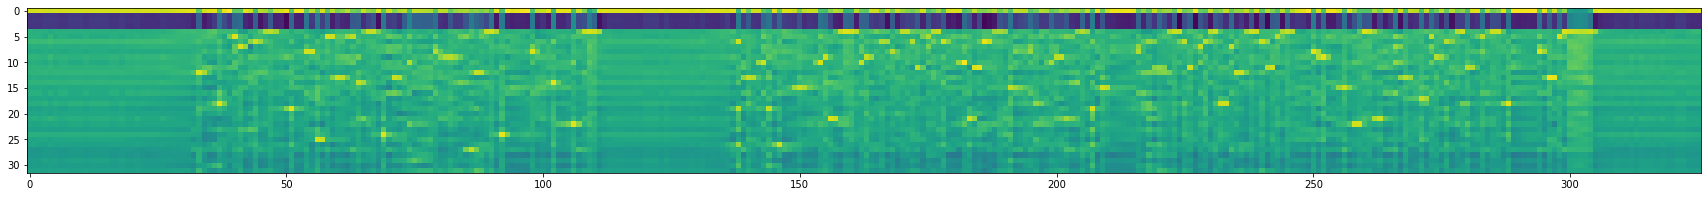

In [61]:
plt.figure(figsize=(30,5))
plt.imshow(logits[0,:,:].permute(1,0).detach().numpy())
plt.show()

In [62]:
print("input_values.shape :",input_values.shape)
print("logits.shape :",logits.shape)
print("predicted_ids.shape :",predicted_ids.shape)

input_values.shape : torch.Size([1, 104560])
logits.shape : torch.Size([1, 326, 32])
predicted_ids.shape : torch.Size([1, 326])


In [63]:
#All the different caracter the tokenizer can produce: 
tokenizer.batch_decode([range(0,33)])

["<s></s><unk> ETAONIHSRDLUMWCFGYPBVK'XJQZ<unk>"]

In [64]:
print("input text   :",ds['text'][1])
print("decoded text :",transcription)

from IPython.display import Audio
Audio(np.array(ds['speech'][1]), rate=20000)
#Audio(np.exp(-np.linspace(0,10,50000))*np.sin(np.linspace(0,3000,50000)), rate=30000)

input text   : SWEAT COVERED BRION'S BODY TRICKLING INTO THE TIGHT LOINCLOTH THAT WAS THE ONLY GARMENT HE WORE
decoded text : ["SWEAT COVERED BRION'S BODY TRICKLING INTO THE TIGHT LOWING CLOTH THAT WAS THE ONLY GARMENT HE WORE"]


# Register hook

In [65]:
class Save:
    def __init__(self):
        self.input = None
        self.output = None
        
    def __call__(self, module, module_in, module_out):
        self.input = module_in
        self.output = module_out

save_feature0 = Save()      
save_feature1 = Save()
save_feature2 = Save()
save_feature3 = Save()
save_feature4 = Save()
save_feature5 = Save()
save_feature6 = Save()

# Register a forward hook on the first convolutional layer
handle0 = model.wav2vec2.feature_extractor.conv_layers[0].conv.register_forward_hook(save_feature0)
handle1 = model.wav2vec2.feature_extractor.conv_layers[1].conv.register_forward_hook(save_feature1)
handle2 = model.wav2vec2.feature_extractor.conv_layers[2].conv.register_forward_hook(save_feature2)
handle3 = model.wav2vec2.feature_extractor.conv_layers[3].conv.register_forward_hook(save_feature3)
handle4 = model.wav2vec2.feature_extractor.conv_layers[4].conv.register_forward_hook(save_feature4)
handle5 = model.wav2vec2.feature_extractor.conv_layers[5].conv.register_forward_hook(save_feature5)
handle6 = model.wav2vec2.feature_extractor.conv_layers[6].conv.register_forward_hook(save_feature6)

# Compare features

In [66]:
def visualize(signal,sr=16000,logits=False):
    #plot signal
    plt.figure(figsize=(20,5))
    plt.plot(signal)
    plt.title('Signal')

    #plot spectrogram
    spect = librosa.stft(signal, n_fft=400)
    plt.figure(figsize=(20,5))
    librosa.display.specshow(np.abs(spect), sr=sr, x_axis='time', y_axis='hz')
    plt.title('Spectrogramme')

    #compute wav2vec features
    input_values = tokenizer(signal, return_tensors="pt", padding="longest").input_values  # Batch size 1
    output = model(input_values,output_hidden_states=True)

    if not logits:
      CNNfeatures=output.hidden_states[0][0].permute(1,0).detach().numpy()
      # plot wav2vec features
      plt.figure(figsize=(20,5))
      librosa.display.specshow(np.abs(CNNfeatures), sr=sr, x_axis='time', y_axis='hz')
      plt.title('wav2vec 2.0 CNN features')
      plt.show()

    if logits:
      logits=output.logits[0,:,:].permute(1,0).detach().numpy()
      plt.figure(figsize=(20,5))
      librosa.display.specshow(np.abs(logits), sr=sr, x_axis='time', y_axis='hz')
      plt.title('wav2vec 2.0 logits')
      plt.show()


## Comapre features of pure sound

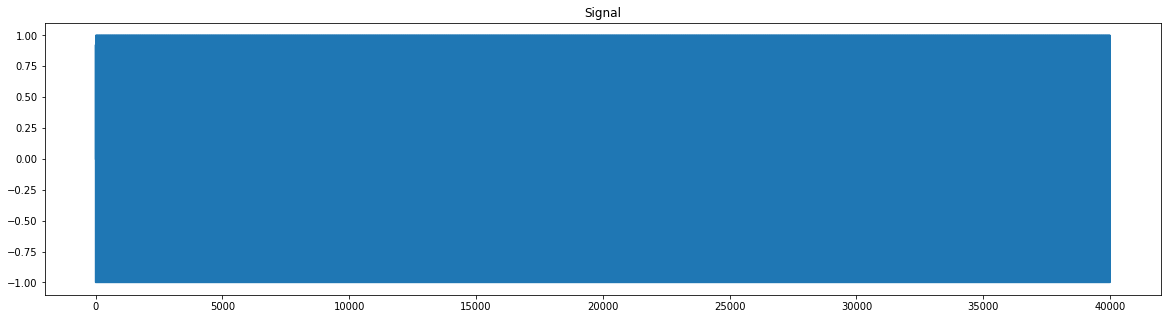

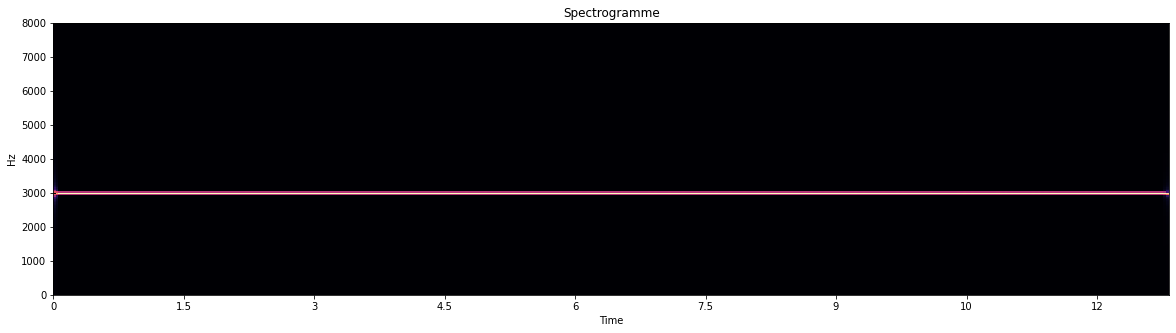

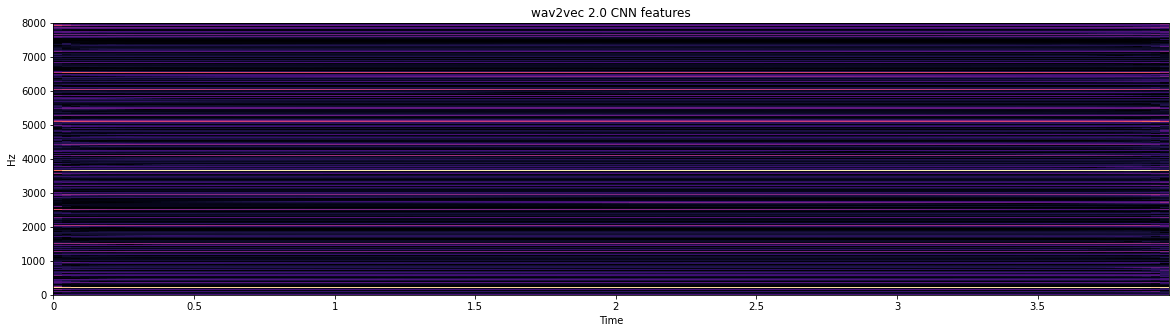

In [67]:
signal = librosa.tone(frequency=3000, sr=16000, length=40000)
visualize(signal)
Audio(signal, rate=16000)

## Comapre features of chirp

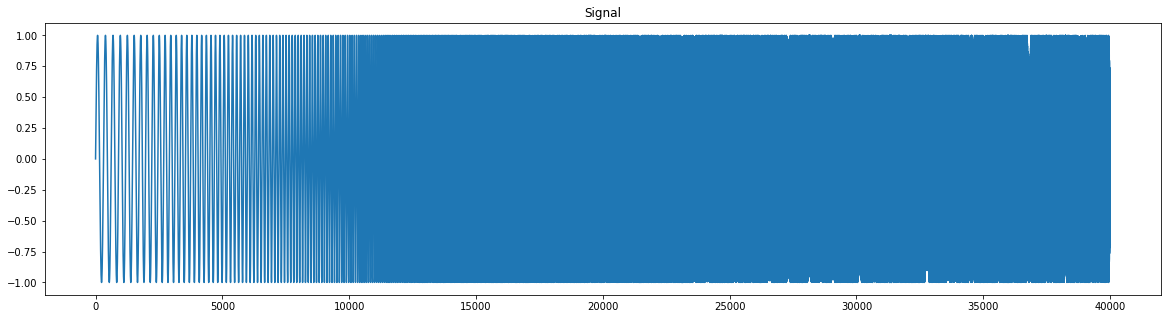

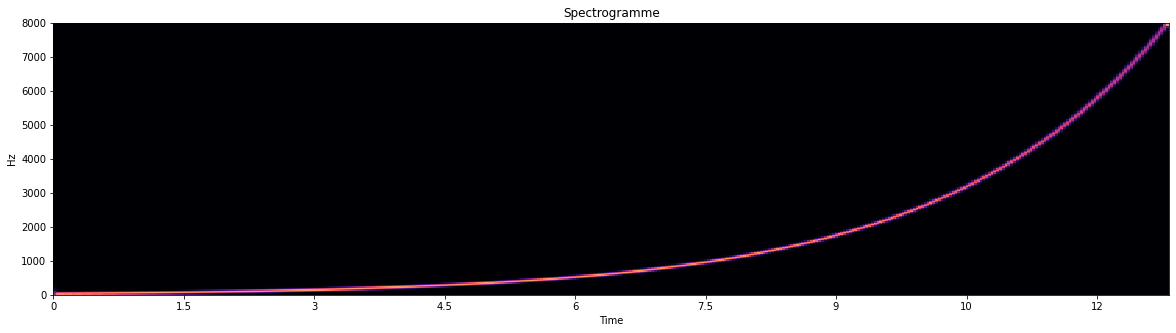

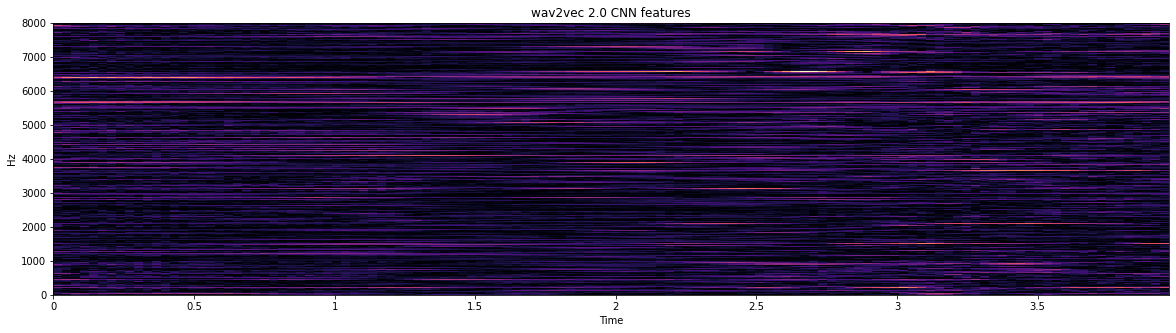

In [68]:
signal = librosa.chirp(fmin=50, fmax=8000, sr=16000, length=40000)
visualize(signal)
Audio(signal, rate=16000)

## Comapre features of white noise

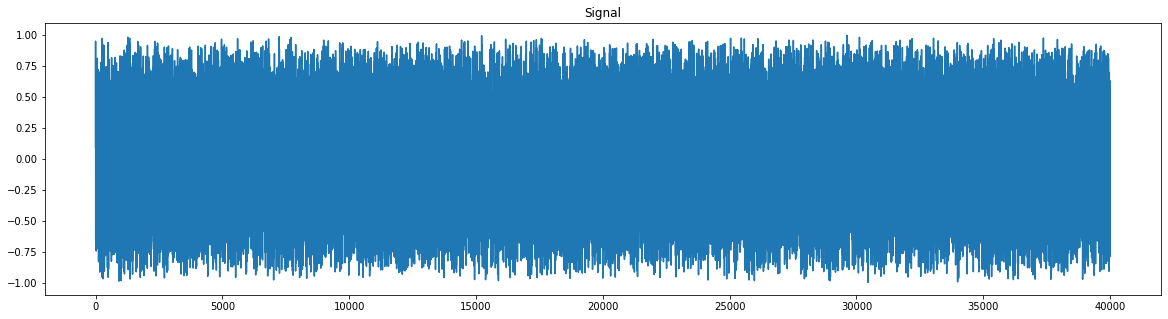

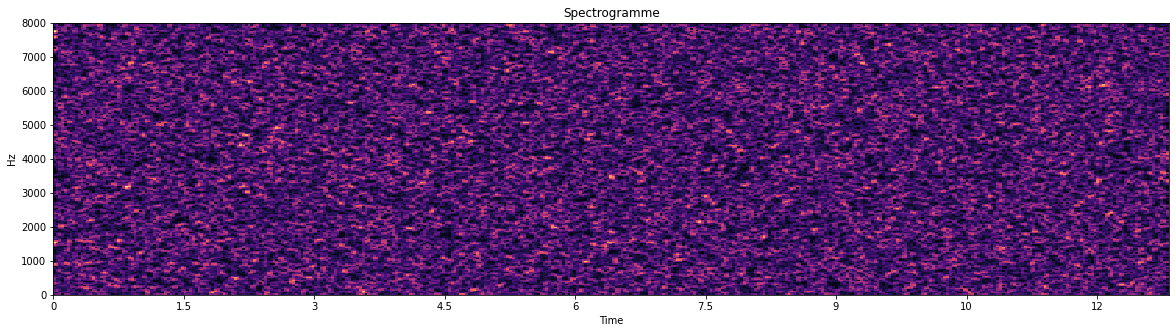

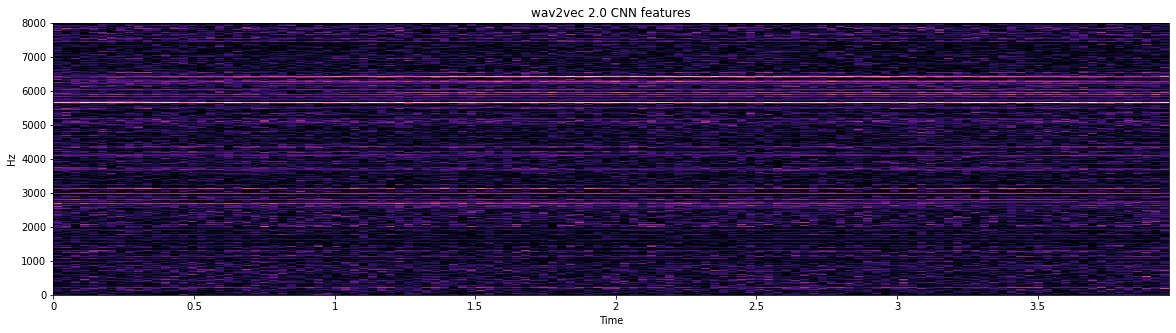

In [69]:
signal=np.random.rand(40000)-np.random.rand(40000)
visualize(signal)
Audio(signal, rate=16000)

## Comapre features of speech

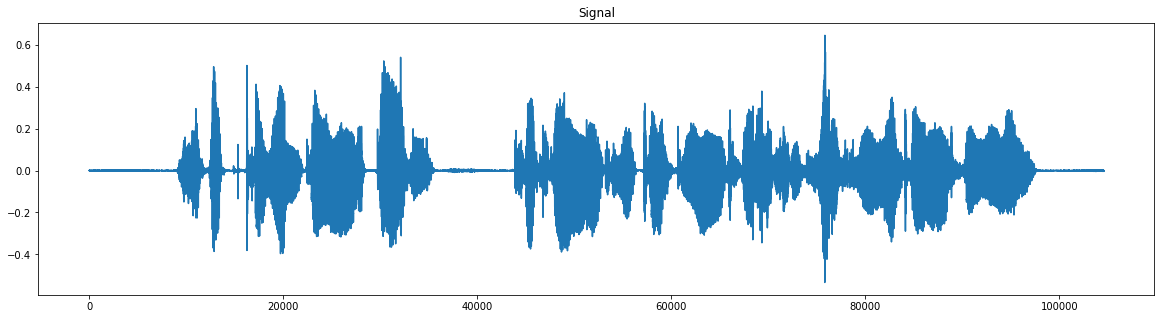

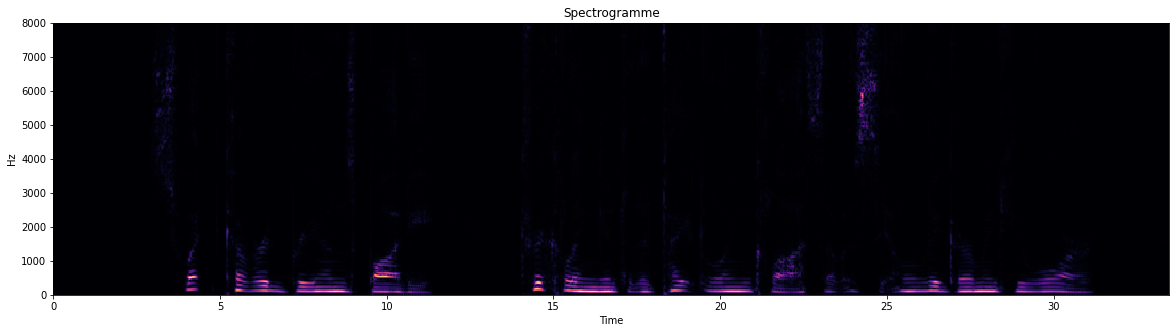

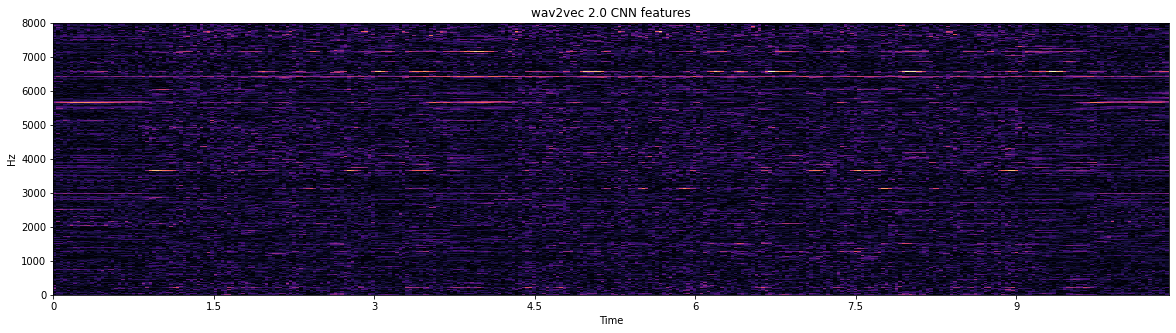

In [70]:
signal=np.array(ds['speech'][1])
visualize(signal,logits=False)
Audio(signal, rate=16000)

## Comapre features of 'aroch'

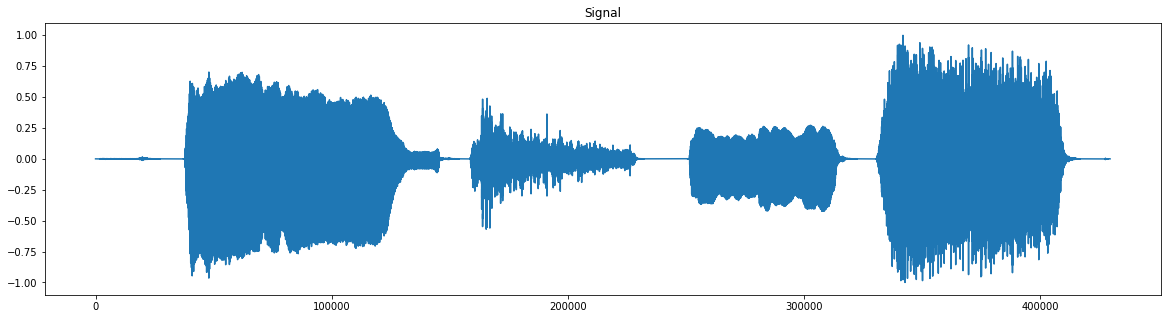

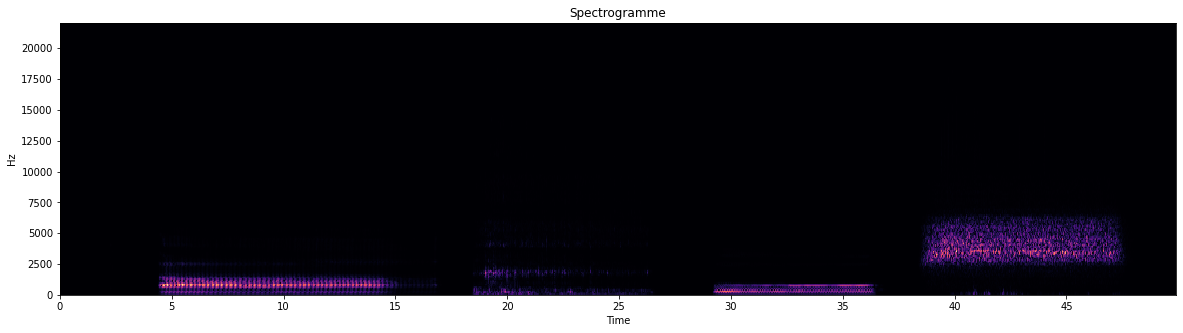

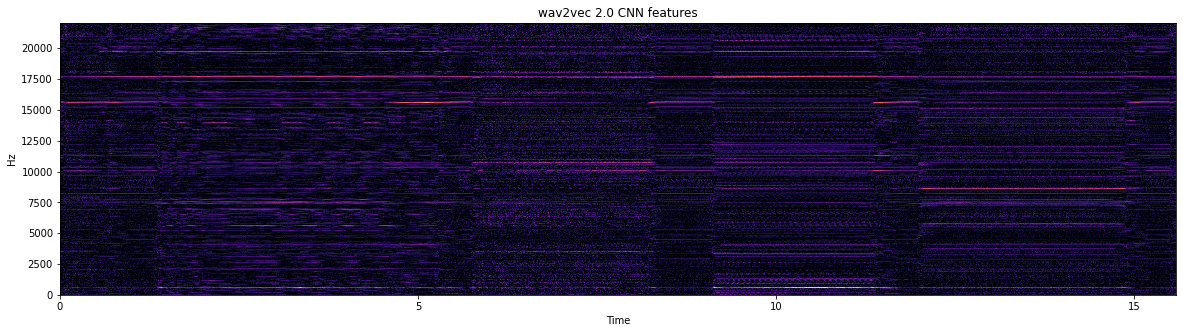

In [71]:
signal, sampling_rate = open_audio('/content/aroch.mp3')
visualize(signal,sr=sampling_rate)
Audio(signal, rate=sampling_rate)

## Details of layers in CNN

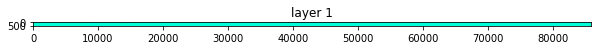

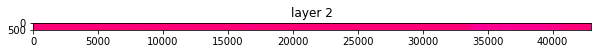

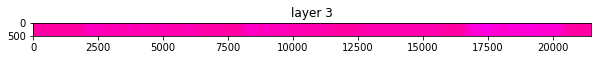

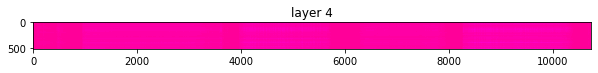

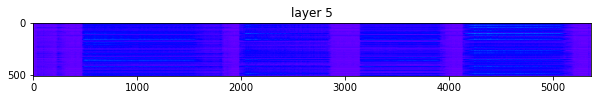

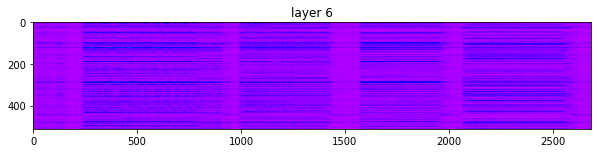

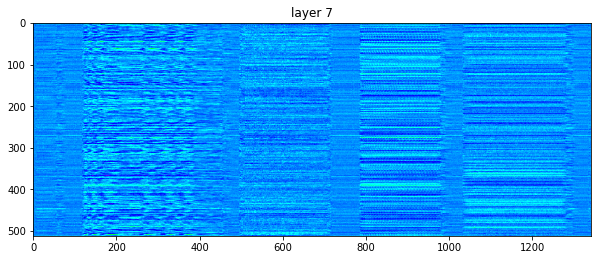

In [72]:
plt.figure(figsize=(10,10))
plt.imshow(save_feature0.output[0].detach().numpy(),cmap='hsv')
plt.title('layer 1')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(save_feature1.output[0].detach().numpy(),cmap='hsv')
plt.title('layer 2')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(save_feature2.output[0].detach().numpy(),cmap='hsv')
plt.title('layer 3')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(save_feature3.output[0].detach().numpy(),cmap='hsv')
plt.title('layer 4')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(save_feature4.output[0].detach().numpy(),cmap='hsv')
plt.title('layer 5')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(save_feature5.output[0].detach().numpy(),cmap='hsv')
plt.title('layer 6')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(save_feature6.output[0].detach().numpy(),cmap='hsv')
plt.title('layer 7')
plt.show()